In [1]:
import csv
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from collections import defaultdict

Load the training data. These are the first two PCs of the G-vector for a small RNA.

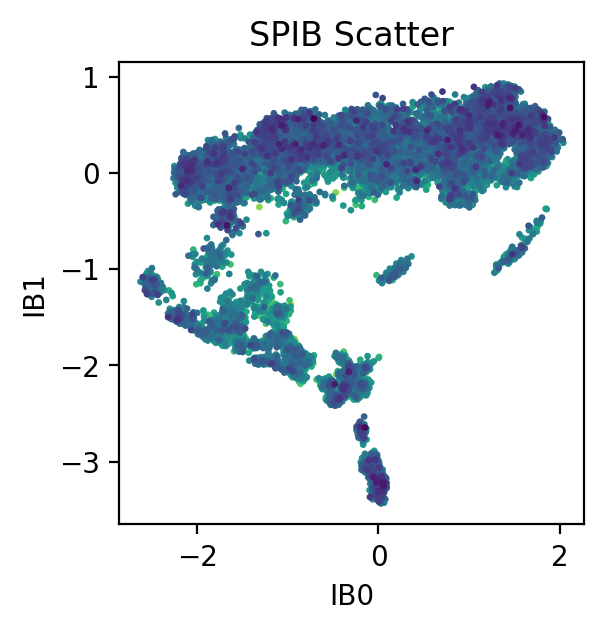

In [2]:
in_path = "../example/6E1W.csv"

pc1_vals = []
pc2_vals = []
temperature = []
potential = []
indices = []

# Load using csv module
with open(in_path, "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        indices.append(row["index"])
        pc1_vals.append(float(row["ib0"]))
        pc2_vals.append(float(row["ib1"]))
        temperature.append(float(row['temperature']))
        potential.append(float(row['potential']))

# Make a scatter plot (no styles/colors specified)
plt.figure(dpi=200, figsize=(3,3));
pc1_vals = np.array(pc1_vals)
pc2_vals = np.array(pc2_vals)
potential = np.array(potential)
idxs = np.argsort(potential)[::-1]

plt.scatter(pc1_vals[idxs], pc2_vals[idxs], c=potential[idxs], s=2);
plt.xlabel("IB0");
plt.ylabel("IB1");
plt.title("SPIB Scatter");
plt.show();
plt.close();

Custom loader class.

In [3]:
class PCADataset:
    def __init__(self, csv_path):
        self.csv_path = Path(csv_path)
        self.data = []
        self._load()

    def _load(self):
        import csv
        import numpy as np

        with self.csv_path.open("r", newline="") as f:
            reader = csv.DictReader(f)
            rows = list(reader)  # <-- materialize iterator

        # First pass: collect temperature & potential
        T_ = np.array([float(r["temperature"]) for r in rows], dtype=float)
        potential_ = np.array([float(r["potential"]) for r in rows], dtype=float)

        # Experiment with standardizing potential energy and kinetic temperature into one variable
        # merged = potential_ / T_
        merged = potential_ 
        min_, sig = np.min(merged), np.std(merged)
        if sig == 0:
            sig = 1.0  # avoid division by zero; or handle however you prefer

        # Second pass: build self.data
        for r, m in zip(rows, merged):
            index = r["index"]
            ib0 = float(r["ib0"])
            ib1 = float(r["ib1"])
            norm_val = (m - min_) / sig  # normalized potential/T

            self.data.append((index, ib0, ib1, norm_val))

    def __len__(self):
        return len(self.data)

    def _perturb(self, val, scale=5e-2):
        noise = scale * (2 * np.random.uniform() - 1)
        return val + noise

    def __getitem__(self, i):
        index, ib0, ib1, val = self.data[i]
        temps = np.array([[val]], dtype=float)       # (1, 1)
        coords = np.zeros((2, 2), dtype=float)       # (2, 2)
        coords[0, :] = [ib0, ib1]
        coords[1, :] = [self._perturb(val) for _ in range(2)]
        return index, torch.Tensor(temps), torch.Tensor(coords)


In [4]:
from tm.architectures.mlp import MLP
from tm.architectures.unet_1d import Unet1D

from tm.core.backbone import MLPBackbone, ConvBackbone
from tm.core.diffusion_process import VPDiffusion
from tm.core.prior import GlobalEquilibriumHarmonicPrior as Prior
from tm.core.diffusion_model import DiffusionTrainer, DiffusionSampler
from tm.core.utils import next_divisible_by_groups
from torch.utils.data import RandomSampler

In [5]:
train_loader = PCADataset(in_path)

In [6]:
full_shape = [1] + list(train_loader.__getitem__(0)[-1].shape)
full_shape

[1, 2, 2]

In [7]:
train_loader = PCADataset(in_path)

train_sampler = RandomSampler(train_loader)

Here I tested an MLP and my Franken-Unet. The Unet matches the prior better than the MLP while having a lower memory footprint -- though I did spend much more time optimizing the Unet compared to the MLP.

In [8]:
# model =MLP(dim=128, #recommend dim=128 if enough memory
#            num_resolutions=8,
#            mlp_hidden_mult=8,
#            dropout=0.05,
#            learned_variance=False,
#            self_condition=True,
#            resnet_block_groups=8,
#            learned_sinusoidal_cond=True,
#            channels=2
# )

# backbone = MLPBackbone(model=model,
#                        lr=1e-5,
#                        eval_mode="train",
#                        self_condition=True,
#                       )



model =Unet1D(dim=128, #recommend dim=128 if enough memory
           num_resolutions=4,
           self_condition=True,
           resnet_block_groups=8,
           learned_sinusoidal_cond=True,
           channels=2
)

# Backbone will automatically use CUDA if it is available -- otherwise CPU.
backbone = ConvBackbone(model=model,
                        data_shape=full_shape[-1],
                        target_shape=next_divisible_by_groups(full_shape[-1], 8),
                        num_dims=3,
                        lr=1e-5,
                        eval_mode="train",
                        self_condition=True,
                        interpolate=True
                      )

diffusion = VPDiffusion(num_diffusion_timesteps=100)

prior = Prior(shape=full_shape, channels_info={"coordinate": [0], "fluctuation": [1]})

Using device  cuda for TM


In [9]:
trainer = DiffusionTrainer(diffusion,
                           backbone,
                           train_loader,
                           prior,
                           model_dir='../example/models',
                           network_pred_type='noise',
                           train_sampler=train_sampler,
                           )

In [10]:
trainer.train(100, loss_type="l2", batch_size=32)

epoch: 0 | train loss: 1.608
epoch: 1 | train loss: 1.446
epoch: 2 | train loss: 1.410
epoch: 3 | train loss: 1.403
epoch: 4 | train loss: 1.401
epoch: 5 | train loss: 1.398
epoch: 6 | train loss: 1.401
epoch: 7 | train loss: 1.388
epoch: 8 | train loss: 1.380
epoch: 9 | train loss: 1.389
epoch: 10 | train loss: 1.370
epoch: 11 | train loss: 1.370
epoch: 12 | train loss: 1.376
epoch: 13 | train loss: 1.373
epoch: 14 | train loss: 1.376
epoch: 15 | train loss: 1.370
epoch: 16 | train loss: 1.380
epoch: 17 | train loss: 1.371
epoch: 18 | train loss: 1.380
epoch: 19 | train loss: 1.358
epoch: 20 | train loss: 1.355
epoch: 21 | train loss: 1.355
epoch: 22 | train loss: 1.384
epoch: 23 | train loss: 1.365
epoch: 24 | train loss: 1.358
epoch: 25 | train loss: 1.364
epoch: 26 | train loss: 1.363
epoch: 27 | train loss: 1.360
epoch: 28 | train loss: 1.353
epoch: 29 | train loss: 1.366
epoch: 30 | train loss: 1.363
epoch: 31 | train loss: 1.367
epoch: 32 | train loss: 1.344
epoch: 33 | train lo

In [11]:
backbone.load_model('../example/models', epoch='latest')

load_state using device choice: cuda


In [12]:
diffusion = VPDiffusion(num_diffusion_timesteps=10) # time mesh does not have to be the same as during training
sampler = DiffusionSampler(diffusion, backbone, train_loader, prior, network_pred_type='noise')

Simple consistency test to verify that the model is working properly. Push the training data forward through the diffusion process to get prior (latent) representations. Verify that they are gaussian distributed (or at least close to). Then take the prior reps and use them as initial conditions for the generative process. If everything is working properly, then we should recover the training distribution. 

In [17]:
# Training data --> Prior reps (deterministic forward process)

output_dict = defaultdict(list)
direction = 'forward'
T = 1

# If OOM error reduce batch size
data_loader = torch.utils.data.DataLoader(train_loader, batch_size=1000, shuffle=False, pin_memory=True)

for batch_index, (index, temperatures, b) in enumerate(tqdm(data_loader, desc="Processing batches")):
    # print(index)
    batch_size = b.size(0)
    for index_ in index:
        if index_ not in output_dict.keys():
            output_dict[index_] = {'target': [], 'prior': [], 'delta_log_pq': [], 'log_p': [], 'log_q': []}
    # else:
    #     output_dict[index] = {'target': [], 'prior': [], 'delta_log_pq': [], 'log_p': [], 'log_q': []}

    output_dict_ = sampler.sample_batch(x0=b, 
                                        mode=direction, 
                                        eta=0, # 0 is ODE, 1 is SDE
                                        gamma=0, # control some of the channels (0 is no control)
                                        batch_size=batch_size,
                                        temperatures=T, # can be scalar of vector (len is num samples)
                                        likelihood=True,
                                        control_dict={}, 
                                        pred_type='noise')

    for i_, index_ in enumerate(index):
        for k,v in output_dict_.items():
            output_dict[index_][k] = output_dict_[k][i_]

Processing batches:   0%|                                            | 0/20 [00:00<?, ?it/s]/home/lukas/micromamba/envs/thermomaps/lib/python3.11/site-packages/torch/nn/functional.py:4735: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_upsample_nearest_exact1d. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1762103288612/work/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return torch._C._nn._upsample_nearest_exact1d(input, output_size, scale_factors)
Processing batches: 100%|███████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


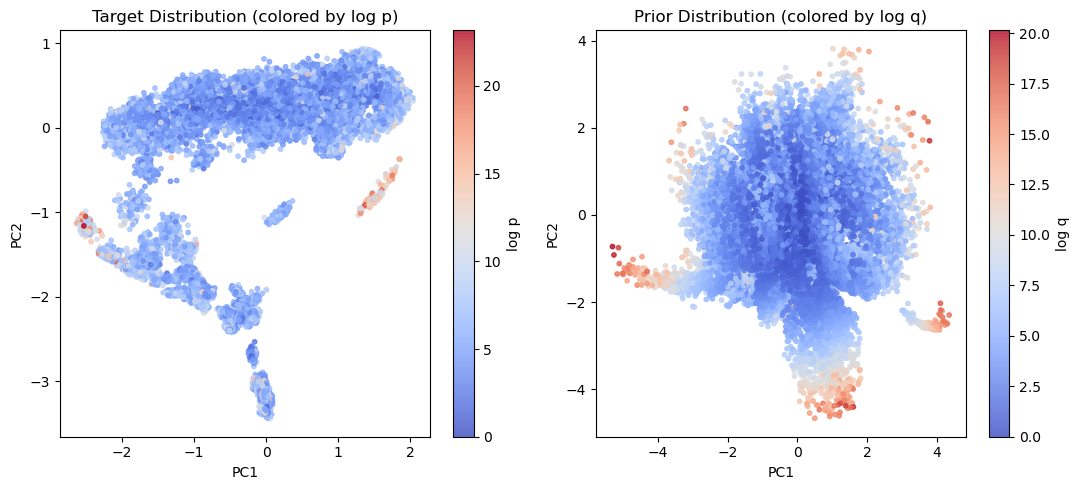

In [18]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    if entry:
        try:
            targets.append(entry["target"][0])  # 0 - coordinates, 1 - temperatures
            priors.append(entry["prior"][0])
            logp.append(float(entry["log_p"]))
            logq.append(float(entry["log_q"]))
        except:
            None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[:, 0], targets[:, 1], c=logp, cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

sc2 = axes[1].scatter(priors[:, 0], priors[:, 1], c=logq, cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

plt.tight_layout()
plt.show()


Save the prior reps.

In [19]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
        try:
            targets.append(entry["target"][None,:,:])  # 0 - coordinates, 1 - temperatures
            priors.append(entry["prior"][None,:,:])
            logp.append(float(entry["log_p"]))
            logq.append(float(entry["log_q"]))
        except:
            None
targets_ = np.array(targets).squeeze()
priors_ = np.array(priors).squeeze()


In [20]:
np.save('prior_endpoints.npy', priors_)

In [21]:
priors_ = np.load('prior_endpoints.npy')

In [24]:
# Prior reps --> Training data (deterministic reverse process)

# Parameters
# for T in np.linspace(0.1,10,0.1):

batch_size = 1000
N = priors_.shape[0]     # or: N = priors_.shape[0]
T = 1
direction = "reverse"

output_dict = {}  # will hold N unique indices: 0..N-1

# Make sure N matches priors_
N = priors_.shape[0]
num_batches = math.ceil(N / batch_size)

for b_ix in tqdm(range(num_batches)):
    start = b_ix * batch_size
    end   = min(start + batch_size, N)
    bs    = end - start
    if bs <= 0:
        break

    # Slice this batch of prior points
    b_np = priors_[start:end]                 # shape (bs, ...)
    # If priors_ is numpy; if it's already torch, you can skip as_tensor
    b = torch.as_tensor(b_np, dtype=torch.float32)  # .to(device) if needed

    # Run sampler on this batch (push prior points backward)
    output_dict_batch = sampler.sample_batch(
        x0=b,
        mode=direction,
        eta=0,                  # 0 = ODE, 1 = SDE (if implemented inside)
        gamma=0,                # no control
        batch_size=bs,
        temperatures=T,         # scalar or vector; same as before
        likelihood=True,
        control_dict={},
        network_pred_type="noise",   # NOTE: use network_pred_type, not pred_type
    )

    # Store results with unique global indices
    # Assumes output_dict_batch fields have shape (bs, ...)
    for i in range(bs):
        idx = start + i
        output_dict[idx] = {
            "target":       output_dict_batch["target"][i],
            "prior":        output_dict_batch["prior"][i],
            "delta_log_pq": output_dict_batch["delta_log_pq"][i],
            "log_p":        output_dict_batch["log_p"][i],
            "log_q":        output_dict_batch["log_q"][i],
        }


 15%|████████▍                                               | 3/20 [00:03<00:19,  1.15s/it]


KeyboardInterrupt: 

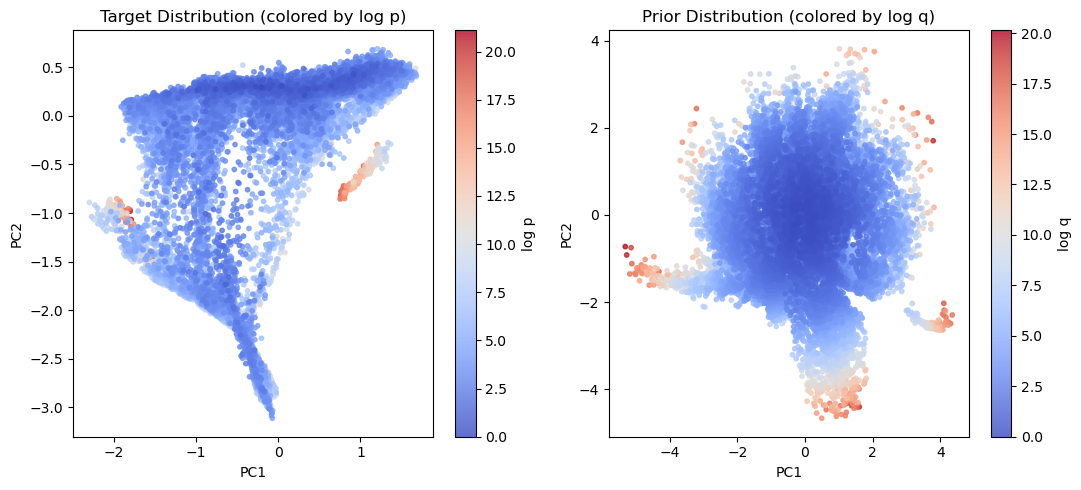

In [23]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    try:
        targets.append(entry["target"][0])  # coordinate row
        priors.append(entry["prior"][0])
        logp.append(float(entry["log_p"]))
        logq.append(float(entry["log_q"]))
    except:
        None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

idxs = np.argsort(logp)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[idxs, 0], targets[idxs, 1], c=logp[idxs], cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

idxs = np.argsort(logq)[::-1]

sc2 = axes[1].scatter(priors[idxs, 0], priors[idxs, 1], c=logq[idxs], cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

plt.tight_layout()
plt.show()


The code below enables the user to generate samples from the training distribution by sampling from the prior across a range of temperatures.

In [13]:
import math
from tqdm import tqdm
import torch
import numpy as np

# Parameters
dT = 0.05
T_range = np.arange(dT, 8, dT)
T_range = np.round(T_range, 3)

logZ_T = {}
outputs_T = {}

for T in tqdm(T_range):

    batch_size = 1000
    N = 50000
    direction = "reverse"
    
    output_dict = {}  # will hold N unique indices: 0..N-1
    
    # Make sure N matches priors_
    num_batches = math.ceil(N / batch_size)
    
    for b_ix in range(num_batches):
        start = b_ix * batch_size
        end   = min(start + batch_size, N)
        bs    = end - start
        if bs <= 0:
            break
    
        b = prior.sample(batch_size=bs, temperatures=T)
    
        # Run sampler on this batch (push prior points backward)
        output_dict_batch = sampler.sample_batch(
            x0=b,
            mode=direction,
            eta=0,                  # 0 = ODE, 1 = SDE (if implemented inside)
            gamma=1,                # no control
            batch_size=bs,
            temperatures=T,         # scalar or vector; same as before
            likelihood=True,
            control_dict={1:T},
            network_pred_type="noise",   # NOTE: use network_pred_type, not pred_type
        )
    
        # Store results with unique global indices
        # Assumes output_dict_batch fields have shape (bs, ...)
        for i in range(bs):
            idx = start + i
            delta_log_pq = output_dict_batch["delta_log_pq"][i]
            logq = output_dict_batch["log_q"][i]
            output_dict[idx] = {
                "target":       output_dict_batch["target"][i],
                "prior":        output_dict_batch["prior"][i],
                "delta_log_pq": output_dict_batch["delta_log_pq"][i],
                "log_p":        logq + delta_log_pq,
                "log_q":        output_dict_batch["log_q"][i],
            }
    
    logps = torch.stack([torch.as_tensor(d['log_p']) for d in output_dict.values()])  # shape (N, ...)
    logZ = torch.logsumexp(-logps, dim=0)
    # Z = torch.exp(logZ)
    logZ_T[T] = logZ
    outputs_T[T] = output_dict


  0%|                                                               | 0/159 [00:00<?, ?it/s]/home/lukas/micromamba/envs/thermomaps/lib/python3.11/site-packages/torch/nn/functional.py:4735: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::_upsample_nearest_exact1d. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1762103288612/work/aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  return torch._C._nn._upsample_nearest_exact1d(input, output_size, scale_factors)
100%|██████████████████████████████████████████████████| 159/159 [5:10:31<00:00, 117.18s/it]


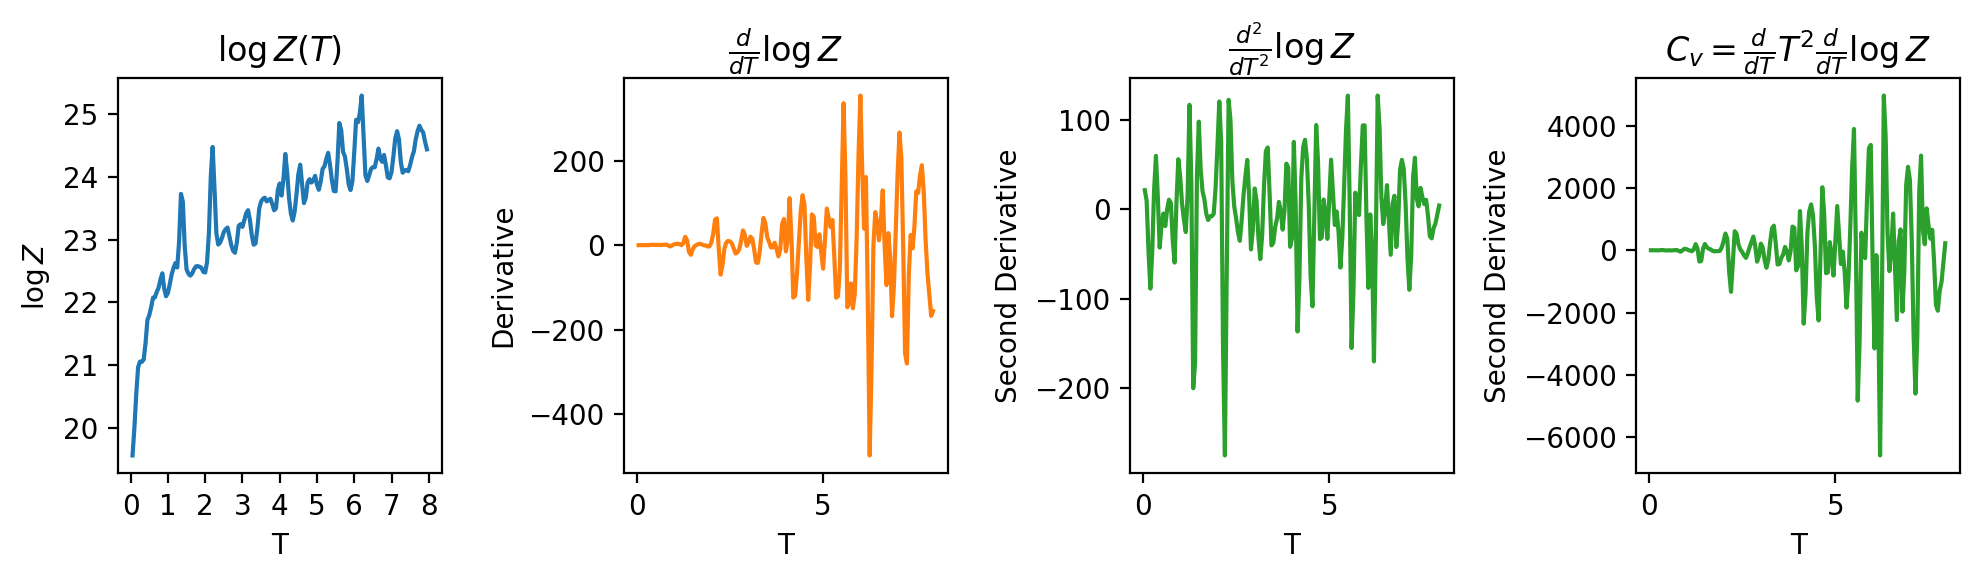

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d



# Example data
T = np.array([k for k in logZ_T.keys()])
y = np.array([v for v in logZ_T.values()])
y = gaussian_filter1d(y, 1)

# First derivative: d(logZ)/dT
dlnZ_dT = np.gradient(y, T)

# Second derivative: d²(logZ)/dT² (heat capacity–like)
d2lnZ_dT2 = np.gradient(dlnZ_dT, T)

cv = np.gradient(dlnZ_dT*T**2, T)


# Create figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 3), dpi=200)

axes[0].plot(T, y, color='C0')
axes[0].set_title(r'$\log Z(T)$')
axes[0].set_xlabel('T')
axes[0].set_ylabel(r'$\log Z$')
axes[0].set_xticks(np.arange(0,9))

axes[1].plot(T, dlnZ_dT*T**2, color='C1')
axes[1].set_title(r'$\frac{d}{dT} \log Z$')
axes[1].set_xlabel('T')
axes[1].set_ylabel('Derivative')

axes[2].plot(T, d2lnZ_dT2, color='C2')
axes[2].set_title(r'$\frac{d^2}{dT^2} \log Z$')
axes[2].set_xlabel('T')
axes[2].set_ylabel('Second Derivative')

axes[3].plot(T, cv, color='C2')
axes[3].set_title(r'$C_v = \frac{d}{dT} T^2 \frac{d}{dT} \log Z$')
axes[3].set_xlabel('T')
axes[3].set_ylabel('Second Derivative')

plt.tight_layout()
plt.show()


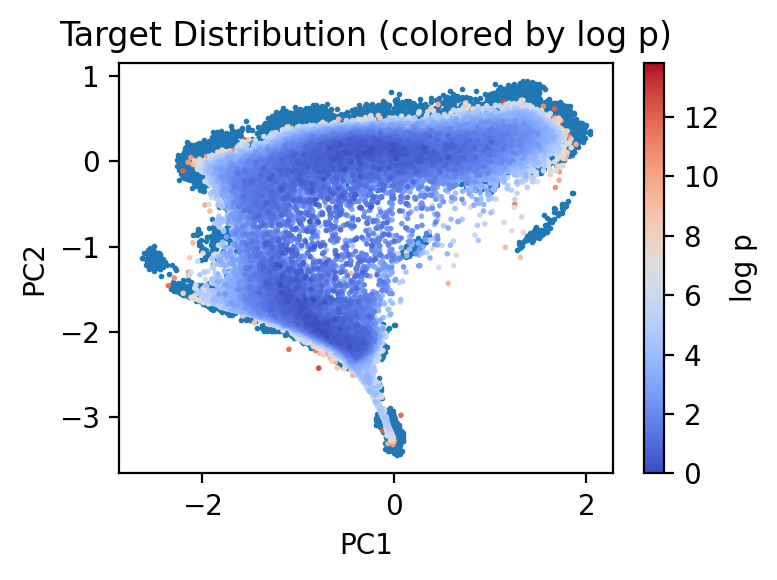

In [151]:
targets, priors = [], []
logp, logq = [], []

T = 3

for entry in outputs_T[T].values():
    try:
        targets.append(entry["target"][0])  # coordinate row
        priors.append(entry["prior"][0])
        logp.append(float(entry["log_p"]))
        logq.append(float(entry["log_q"]))
    except:
        None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

idxs = np.argsort(logp)[::-1]

fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=200)
axes = [axes]
sc1 = axes[0].scatter(targets[idxs, 0], targets[idxs, 1], c=logp[idxs], cmap='coolwarm', s=1, alpha=1)
axes[0].scatter(pc1_vals, pc2_vals, s=1, zorder=-1)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

idxs = np.argsort(logq)[::-1]

plt.tight_layout()
plt.show()


Look at an individual temperatures

/tmp/ipykernel_790716/819115826.py:44: RuntimeWarning: divide by zero encountered in log
  H = -np.log(H)


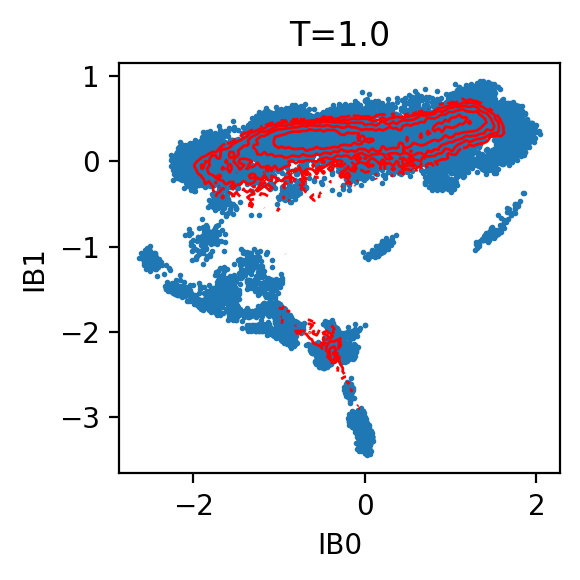

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

targets, priors = [], []
logp, logq = [], []

T = 1.0

for entry in outputs_T[T].values():
    try:
        targets.append(entry["target"][0])  # coordinate row (PC1, PC2)
        priors.append(entry["prior"][0])
        logp.append(float(entry["log_p"]))  # raw log p (can be negative)
        logq.append(float(entry["log_q"]))
    except Exception:
        pass

targets = np.asarray(targets)
priors  = np.asarray(priors)
logp    = np.asarray(logp, dtype=float)
logq    = np.asarray(logq, dtype=float)

# Keep only finite rows
mask_t = np.isfinite(targets).all(axis=1)
mask_lp = np.isfinite(logp)
mask = mask_t & mask_lp
targets = targets[mask]
logp    = logp[mask]

# Boltzmann weights
E_p = -logp
E_p -= E_p.min()
weights_p = np.exp(-E_p)

# --- 2D histogram (targets) ---
nbins = 100
H, xedges, yedges = np.histogram2d(
    targets[:, 0], targets[:, 1],
    bins=nbins,
    weights=weights_p
)
H/=H.ravel().sum()
H = -np.log(H)
H[np.isinf(H)] = np.nan
H = H-np.nanmin(H)
H[H>6] = np.nan

# Bin centers for contour plotting
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters)

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

ax.scatter(pc1_vals, pc2_vals, s=1, zorder=-1)


# Contour lines for clarity
ax.contour(
    X, Y, H.T,
    levels=6,
    colors='r',
    linewidths=1,
    alpha=1
)

ax.set_title(f"T={T}")
ax.set_xlabel("IB0")
ax.set_ylabel("IB1")

plt.tight_layout()
plt.show()


Look at an multiple temperatures side-by-side

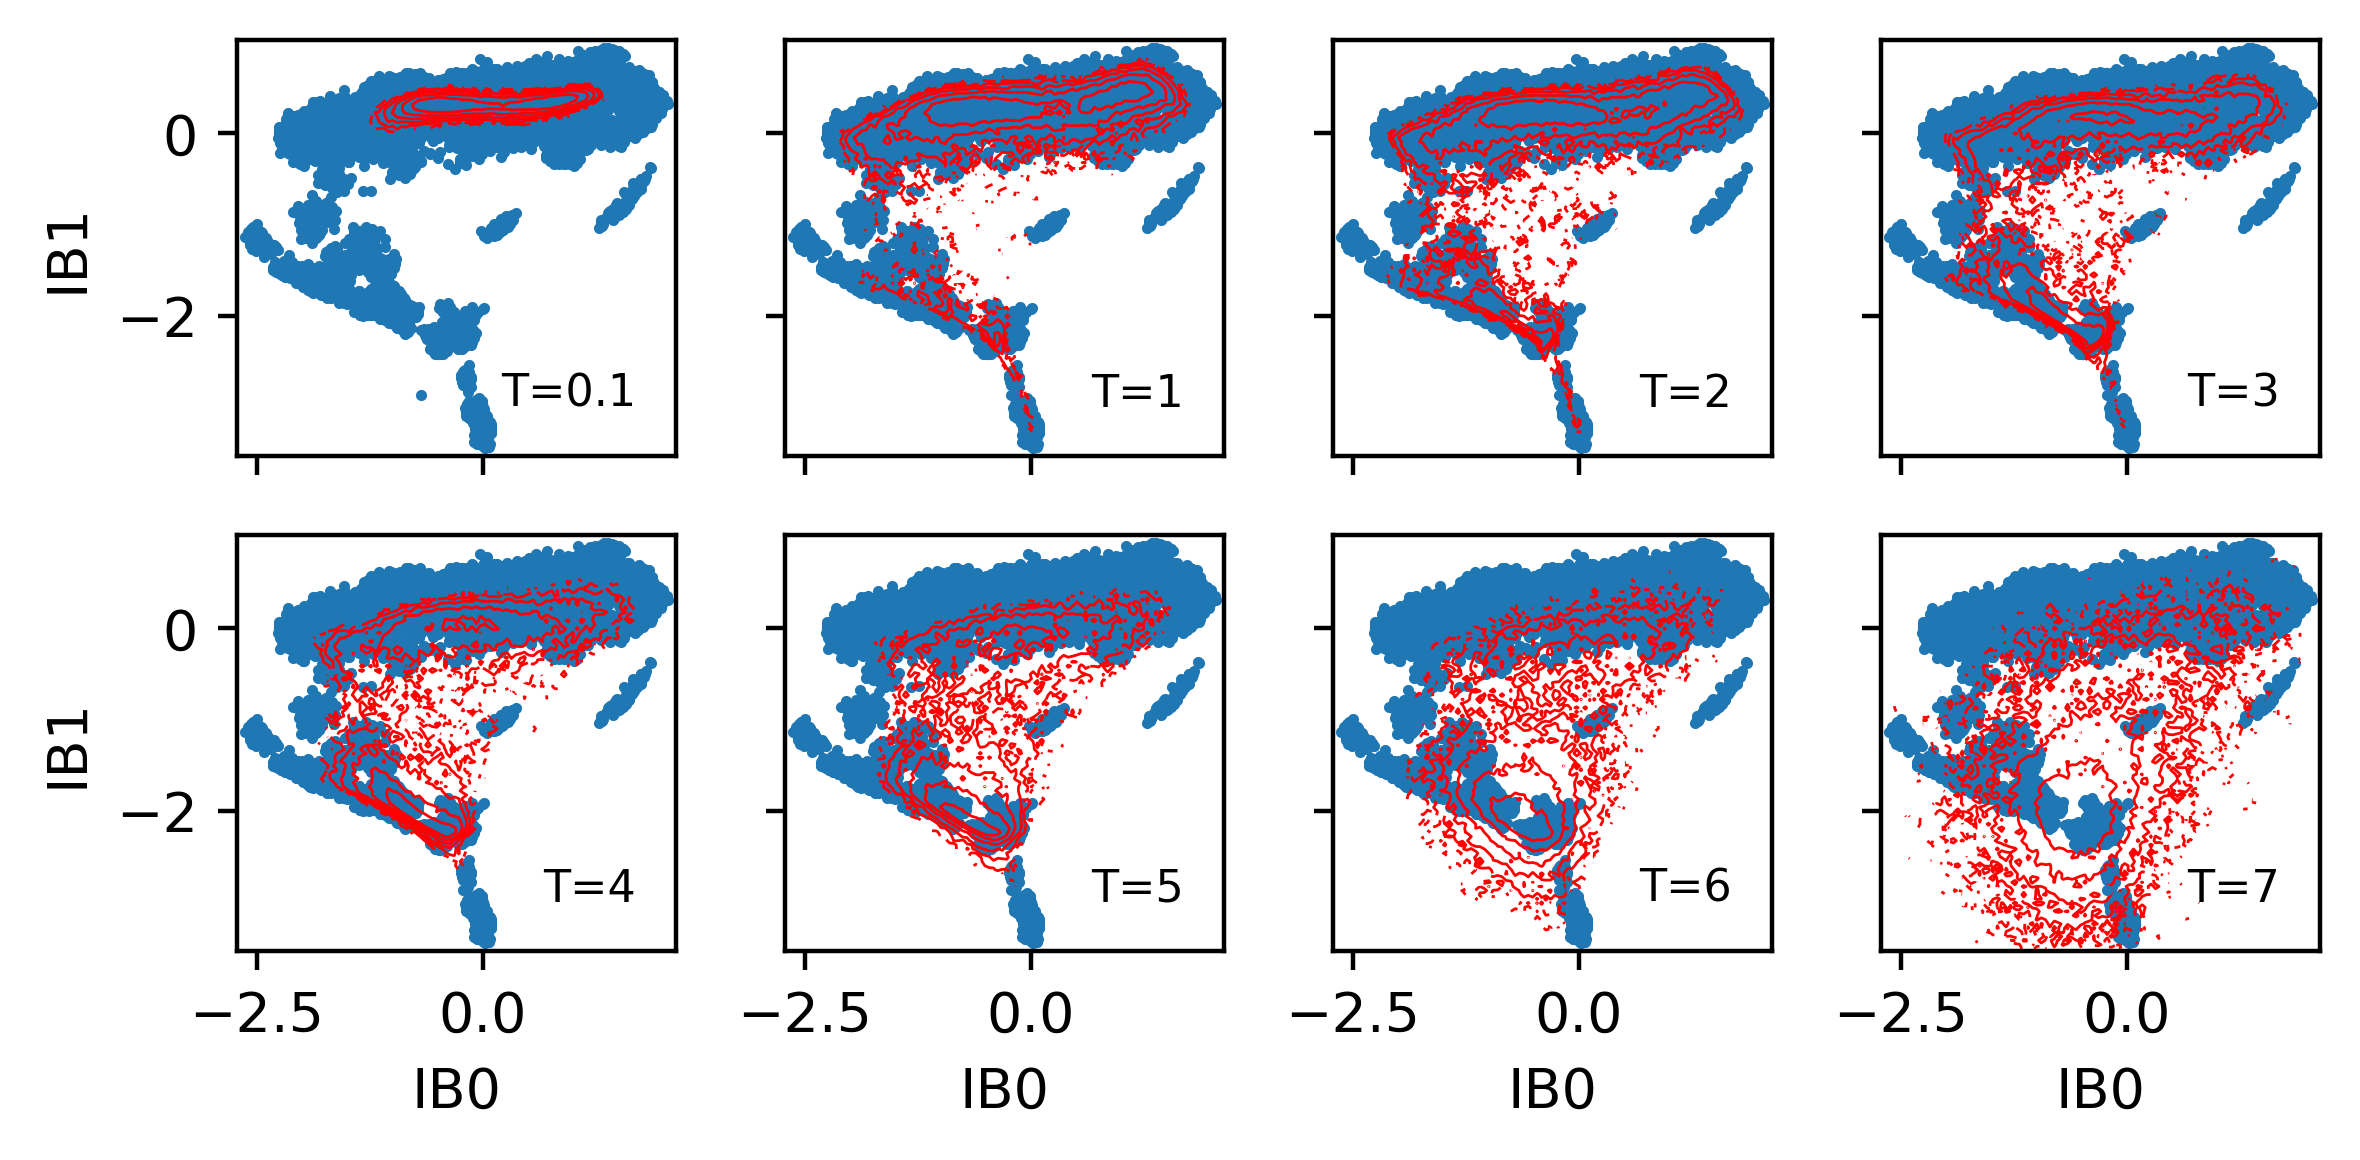

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# --- parameters ---
temps = [0.1] + list(range(1, 9))          # 1..8 inclusive
nbins = 100
ncols = min(4, len(temps))
nrows = int(np.ceil(len(temps) / ncols))-1
levels = 6                          # contour levels

def _get_bucket(T):
    # allow dict keys to be 1 or 1.0, etc.
    return outputs_T[T] if T in outputs_T else outputs_T.get(float(T), None)

# --- prepass to get global XY limits across all T (for consistent axes) ---
xmin = ymin = np.inf
xmax = ymax = -np.inf
valid_T = []
for T in temps:
    bucket = _get_bucket(T)
    if bucket is None: continue

    targets, logp = [], []
    for entry in bucket.values():
        try:
            targets.append(entry["target"][0])  # [pc0, pc1]
            logp.append(float(entry["log_p"]))
        except Exception:
            pass

    if not targets or not logp: 
        continue

    targets = np.asarray(targets, dtype=float)
    logp    = np.asarray(logp, dtype=float)

    # finite mask
    mask_t  = np.isfinite(targets).all(axis=1)
    mask_lp = np.isfinite(logp)
    mask = mask_t & mask_lp
    targets = targets[mask]
    if targets.size == 0: 
        continue

    xmin = min(xmin, np.nanmin(pc1_vals[:]))
    xmax = max(xmax, np.nanmax(pc1_vals[:]))
    ymin = min(ymin, np.nanmin(pc2_vals[:]))
    ymax = max(ymax, np.nanmax(pc2_vals[:]))
    valid_T.append(T)

if not valid_T:
    raise RuntimeError("No valid temperature slices found in outputs_T.")

# Slight padding for nicer layout
pad_x = 0.02 * (xmax - xmin if np.isfinite(xmax - xmin) else 1.0)
pad_y = 0.02 * (ymax - ymin if np.isfinite(ymax - ymin) else 1.0)
xlim = (xmin - pad_x, xmax + pad_x)
ylim = (ymin - pad_y, ymax + pad_y)

# --- plotting ---
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(1.5*ncols, 1.5*nrows), dpi=400)
axes = np.atleast_2d(axes)

for idx, T in enumerate(valid_T):
    r, c = divmod(idx, ncols)
    ax = axes[r, c]
    bucket = _get_bucket(T)

    # collect data for this T
    targets, logp = [], []
    for entry in bucket.values():
        try:
            targets.append(entry["target"][0])  # [pc0, pc1]
            logp.append(float(entry["log_p"]))
        except Exception:
            pass

    targets = np.asarray(targets, dtype=float)
    logp    = np.asarray(logp, dtype=float)

    # finite mask
    mask_t  = np.isfinite(targets).all(axis=1)
    mask_lp = np.isfinite(logp)
    mask = mask_t & mask_lp
    targets = targets[mask]
    logp    = logp[mask]

    # Boltzmann-like weights from logp (as in your example)
    E_p = -logp
    E_p -= E_p.min() if E_p.size else 0.0
    weights_p = np.exp(-E_p) if E_p.size else np.ones_like(E_p)

    # 2D histogram → "free energy"-like surface
    H, xedges, yedges = np.histogram2d(
        targets[:, 0], targets[:, 1],
        bins=nbins, range=[[xlim[0], xlim[1]], [ylim[0], ylim[1]]],
        weights=weights_p # OPTIONAL: COMMENT OUT FOR EQUAL WEIGHTS
    )
    if H.sum() > 0:
        H = H / H.sum()
        with np.errstate(divide='ignore', invalid='ignore'):
            F = -np.log(H)
        F[~np.isfinite(F)] = np.nan
        F = F - np.nanmin(F)
        F[F > 10] = np.nan  # clip for readability
    else:
        F = np.full((nbins, nbins), np.nan)

    # bin centers for contour
    xcenters = 0.5 * (xedges[:-1] + xedges[1:])
    ycenters = 0.5 * (yedges[:-1] + yedges[1:])
    X, Y = np.meshgrid(xcenters, ycenters)

    # light scatter of raw points (optional)
    # ax.scatter(targets[:, 0], targets[:, 1], s=1, alpha=0.25, label=f"T={T}")
    ax.scatter(pc1_vals, pc2_vals, s=1, zorder=-1, 
               label=f"T={T}"
              )

    # contour overlay
    try:
        ax.contour(X, Y, F.T, levels=levels, linewidths=0.5, colors='r')
    except Exception:
        # if too sparse, skip contours
        pass

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    # Axis labeling logic: only leftmost col gets y-label; only bottom row gets x-label
    if c == 0:
        ax.set_ylabel("IB1")
    else:
        ax.set_yticklabels([])

    if r == nrows - 1:
        ax.set_xlabel("IB0")
    else:
        ax.set_xticklabels([])

    # Temperature in legend, no titles
    ax.legend(frameon=False, loc="lower right", fontsize=8)

# Hide any unused subplots
total_axes = nrows * ncols
for k in range(len(valid_T), total_axes):
    r, c = divmod(k, ncols)
    axes[r, c].axis("off")

plt.tight_layout()
plt.show()
